# Evaluating selected cells for COVID-19 classification
***
Jan T. Schleicher, 2022

In this notebook, we evaluate the selected cells for classification of healthy donors and COVID-19 patients. This analysis is based on the data from [Wilk et al. 2021](https://doi.org/10.1084/jem.20210582).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.legend_handler import HandlerTuple
from matplotlib import patheffects as pe
import seaborn as sns
from scipy import stats
import os

import enrichment_plots as ep

%config Completer.use_jedi = False
%matplotlib inline
sns.set_theme(style="ticks", font_scale=1.2)

In [2]:
plot_dir = "../output/figures/blish_status"
os.makedirs(plot_dir, exist_ok=True)

## Plot balanced test accuracies

To choose the best input dimensionality for our model, i.e., the best number of principal components, we look at the balanced accuracies across three random splits of the data.

In [3]:
accuracies = pd.read_csv("../output/model_evaluations/blish_status_balanced_accuracies.csv")
accuracies.n_PCs = accuracies.n_PCs.astype(str)
accuracies_long = pd.melt(accuracies, id_vars="n_PCs", var_name="accuracy_type", value_name="balanced_accuracy")
accuracies_long["accuracy_type"] = accuracies_long["accuracy_type"].str.replace("_balanced_acc", "")

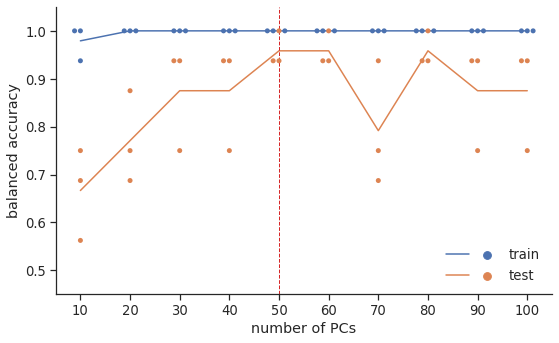

In [4]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(x="n_PCs", y="balanced_accuracy", data=accuracies_long, ax=ax, ci=None,
             hue="accuracy_type", hue_order=["train", "test"])
sns.swarmplot(x="n_PCs", y="balanced_accuracy", data=accuracies_long, ax=ax,
              hue="accuracy_type", hue_order=["train", "test"])
sns.despine()
ax.axvline("50", ls="--", lw=1, c="tab:red")
ax.set_ylim(0.45, 1.05)
ax.set_xlabel("number of PCs")
ax.set_ylabel("balanced accuracy")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=["train", "test"], loc="lower right", handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)},
          frameon=False)
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, "blish_status_balanced_accuracies.svg"), dpi=200);

## Loading data

We import the filter response from the CellCnn model for classifying disease status in the COVID-19 data ([Wilk et al. 2021](https://doi.org/10.1084/jem.20210582)). According to the performance evaluation shown above, this is the model that uses 50 principal components as input. We evaluate the model trained on the first training split of the data. The evaluation is performed on training and test data together.

In [5]:
filter_response = pd.read_csv("../output/filter_responses/blish_status_filter_response.csv",
                             index_col=0)
response_data = pd.read_csv("../data/blish_response_data.csv")
filter_response = filter_response.merge(response_data[["Donor", "Status"]], on="Donor")
meta_data_umap = pd.read_csv("../data/blish_meta_data_umap.csv")
filter_response = filter_response.merge(meta_data_umap[["cell.name", "cell.type.fine", "cell.type.coarse",
                                                        "UMAP_1", "UMAP_2"]], on="cell.name")
filter_response

,Donor,cell.type,cell.name,data_set,response_filter_0,response_filter_1,response_filter_2,response_filter_3,Status,cell.type.fine,cell.type.coarse,UMAP_1,UMAP_2
0,28205-0555d0,Platelet,555_1.100_AAAGAATTACGG,train,-1.391702,-1.171105,-2.715806,-2.186206,COVID,Platelet,Platelet,-0.334269,-0.747272
1,28205-0555d0,CD4 TCM,555_1.1000_CAATCGGTTGCG,train,-0.910292,-0.616430,0.085968,-0.646085,COVID,ISG+ CD14 mono,CD14 mono,-10.161209,1.864213
2,28205-0555d0,Plasmablast,555_1.1001_TCGGCGCTTACA,train,-0.718724,-3.167357,3.547556,-0.702531,COVID,IgA PB,PB,-1.661245,-6.138116
3,28205-0555d0,Eryth,555_1.1002_CCCGGCGCGTAC,train,-0.879374,-0.065317,2.737572,-0.749565,COVID,IgG PB,PB,-10.340357,2.079315
4,28205-0555d0,CD14 Mono,555_1.1003_GGTAGTCAATAC,train,-1.257647,0.543387,3.264910,-0.606864,COVID,ISG+ CD14 mono,CD14 mono,-11.524545,1.723889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94434,55689-0061,CD14 Mono,Imm_061.986_TTACGGATGAAC,test,-1.208146,-0.536193,0.542817,-1.982570,COVID,CD14 mono,CD14 mono,-7.217625,2.144411
94435,55689-0061,CD16 Mono,Imm_061.987_AGGGAATCTGTA,test,0.060716,-0.104529,-0.297998,-1.453484,COVID,CD16 mono,CD16 mono,-7.066542,5.743073
94436,55689-0061,CD14 Mono,Imm_061.992_CACGGCTCTGGC,test,-0.538137,-1.196297,-0.200515,-1.179937,COVID,CD14 mono,CD14 mono,-7.039715,2.469521
94437,55689-0061,CD8 Naive,Imm_061.997_AATCGCGGGGGG,test,-0.883318,-0.611825,-0.009405,-1.083186,COVID,CD4 T,CD4 T,6.466684,-2.365980


## Computing selected cell frequencies per sample

To compare the two classes, we compute the frequencies of cells with a positive filter response per sample. From this, we generate boxplots of selected cell frequencies.

In [6]:
# mark cells with positive filter response as selected
selected_cells_df = filter_response[["Donor", "Status"]].copy()
selected_cells_df = selected_cells_df.merge(filter_response.filter(regex="response_filter_\d*$"),
                                            left_index=True, right_index=True)
for i, col in enumerate(selected_cells_df.filter(regex="response_filter_\d*$").columns):
    selected_cells_df[f"selected_filter_{i}"] = (selected_cells_df[col] > 0)

# count selected and total cells per sample
total_cell_counts = selected_cells_df.groupby(["Donor", "Status"], observed=True).size().reset_index(name="count")
selected_cell_counts = selected_cells_df.groupby(["Donor", "Status"], observed=True).sum()\
    .filter(regex="selected_filter_\d*$").reset_index()\
    .merge(total_cell_counts, on=["Donor", "Status"])

# compute selected cell frequencies per sample
for col in selected_cell_counts.filter(regex="selected_filter_\d*$").columns:
    selected_cell_counts[col + "_freq"] = selected_cell_counts[col] / selected_cell_counts["count"] * 100
display(selected_cell_counts)

,Donor,Status,selected_filter_0,selected_filter_1,selected_filter_2,selected_filter_3,count,selected_filter_0_freq,selected_filter_1_freq,selected_filter_2_freq,selected_filter_3_freq
0,28205-0555d0,COVID,47,1424,2672,594,3657,1.285206,38.939021,73.065354,16.242822
1,28205-0555d2,COVID,738,637,2262,2423,5587,13.209236,11.401468,40.486844,43.368534
2,28205-0556,COVID,46,219,898,308,1816,2.533040,12.059471,49.449339,16.960352
3,28205-0557,COVID,359,825,2591,1648,5503,6.523714,14.991823,47.083409,29.947301
4,28205-0558,COVID,142,2335,3052,891,4249,3.341963,54.954107,71.828666,20.969640
5,28205-0559,COVID,61,767,1552,376,2350,2.595745,32.638298,66.042553,16.000000
6,28205-0561,COVID,537,736,1734,273,3079,17.440728,23.903865,56.316986,8.866515
7,28205-0563,COVID,222,1216,2423,984,3540,6.271186,34.350282,68.446328,27.796610
8,28205-0565,COVID,305,1450,4168,1230,6417,4.753000,22.596229,64.952470,19.167835
9,28205-0566,COVID,142,2190,4175,1067,5884,2.413324,37.219579,70.955133,18.133923


Selected cell frequencies for filter 0


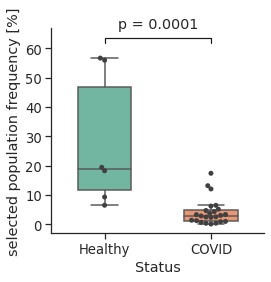

Selected cell frequencies for filter 1


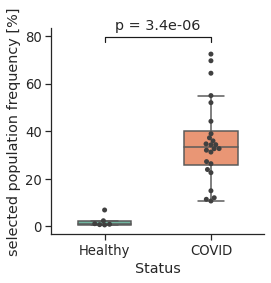

Selected cell frequencies for filter 2


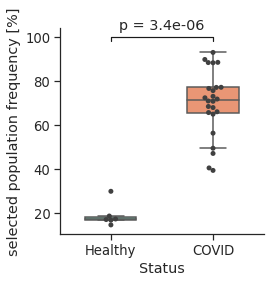

Selected cell frequencies for filter 3


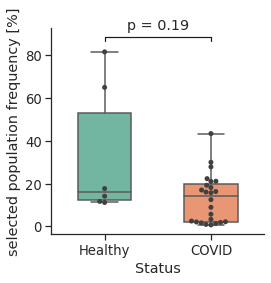

In [7]:
for i, col in enumerate(selected_cell_counts.filter(regex="selected_filter_\d*_freq").columns):
    print(f"Selected cell frequencies for filter {i}")
    ep.plot_selected_cell_frequencies_classification(selected_cells=selected_cell_counts,
                                                     class_col="Status", class_order=["Healthy", "COVID"],
                                                     filter_idx=i, save=True, out_dir=plot_dir)

## Create UMAP plots with filter response

Next, we visualize the cell-wise filter response on the UMAP projection of the data

In [8]:
filter_response[filter_response.filter(regex="response_filter_\d*$").columns] = \
    filter_response.filter(regex="response_filter_\d*$") *\
    (filter_response.filter(regex="response_filter_\d*$") > 0)

UMAP with filter response for filter 0


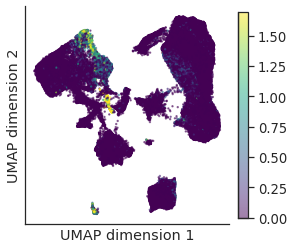

UMAP with filter response for filter 1


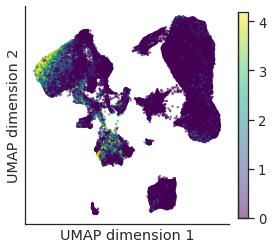

UMAP with filter response for filter 2


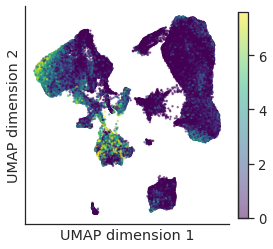

UMAP with filter response for filter 3


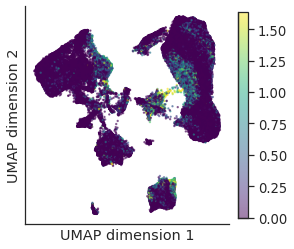

In [9]:
for i, col in enumerate(filter_response.filter(regex="response_filter_\d*$").columns):
    print(f"UMAP with filter response for filter {i}")
    fig, ax = plt.subplots(figsize=(4, 4))

    im = ax.scatter(filter_response["UMAP_1"], filter_response["UMAP_2"], c=filter_response[col],
                    vmin=0, vmax=np.percentile(filter_response[col], 99), cmap="viridis",
                    alpha=.5, edgecolors="face", s=2)
    im.set_rasterized(True)
    plt.colorbar(im, fraction=.046, pad=.04)
    ax.set(xlabel="UMAP dimension 1", ylabel="UMAP dimension 2", xticks=[], yticks=[])
    sns.despine()
    plt.show()
    fig.savefig(os.path.join(plot_dir, f"umap_filter_{i}.svg"), dpi=200)

## Enriched cell types

In the next step, we look at the frequencies and enrichments of different cell types in the selected cells. The threshold for selected cells for each filter is $0.3 \times (\text{maximum filter response})$. We only determine the per-sample frequencies for samples from the majority class among the selected cells.

In [10]:
cell_type_coarse_colors = {"CD4 T": "#F8766D", "CD8 T": "#E38900", "Platelet": "#C49A00",
                           "Neutrophil": "#99A800", "NK": "#53B400", "B": "#00BC56",
                           "PB": "#00C094", "CD14 mono": "#00BFC4", "Developing neutrophil": "#00B6EB",
                           "CD16 mono": "#06A4FF", "Eos/Mast Prog": "#A58AFF",
                           "Prolif Lymph": "#DF70F8", "DC": "#FB61D7", "pDC": "#FF66A8"}

Selected cell type enrichments for filter 0
Group Healthy: 
89.77% of all selected cells


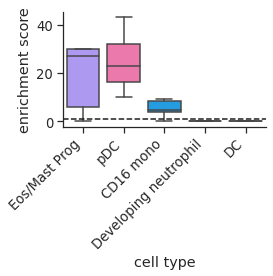

Selected cell type enrichments for filter 1
Group COVID: 
99.93% of all selected cells


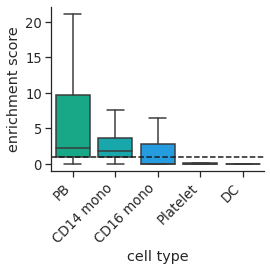

Selected cell type enrichments for filter 2
Group COVID: 
99.40% of all selected cells


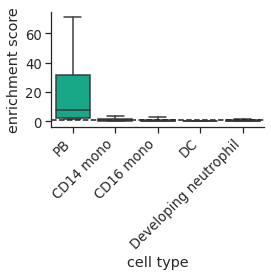

Selected cell type enrichments for filter 3
Group Healthy: 
87.92% of all selected cells


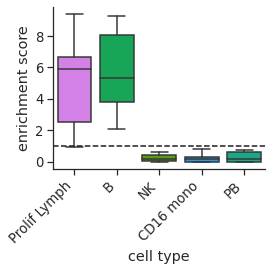

In [11]:
ep.enrichment_per_sample(filter_response, class_col="Status", sample_col="Donor",
                         color_dict=cell_type_coarse_colors, figsize=(4,4), save=True,
                         cell_type_col="cell.type.coarse", ratio_max_response=.3, out_dir=plot_dir)

Selected cell type frequencies for filter 0
Group Healthy: 
89.77% of all selected cells


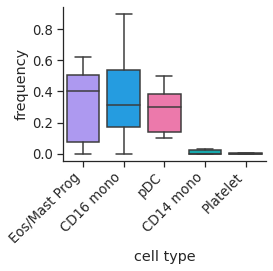

Selected cell type frequencies for filter 1
Group COVID: 
99.93% of all selected cells


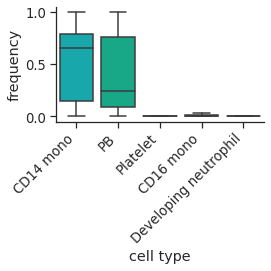

Selected cell type frequencies for filter 2
Group COVID: 
99.40% of all selected cells


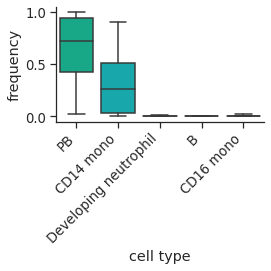

Selected cell type frequencies for filter 3
Group Healthy: 
87.92% of all selected cells


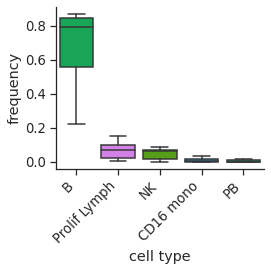

In [12]:
ep.frequency_per_sample(filter_response, class_col="Status", sample_col="Donor",
                        color_dict=cell_type_coarse_colors, figsize=(4,4), save=True,
                        cell_type_col="cell.type.coarse", ratio_max_response=.3, out_dir=plot_dir)

### Pie charts selected proportion of cell type

Additionally, we also show the proportion of cells of a cell type that were selected for the two most frequently selected cell types for the first and second filter.

Proportion of cells selected by filter 0 for cell type 'Eos/Mast Prog' (out of all cells of this cell type)


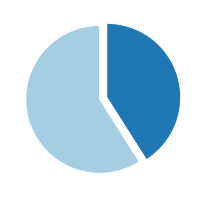

Proportion of cells selected by filter 0 for cell type 'CD16 mono' (out of all cells of this cell type)


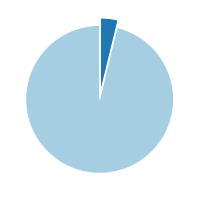

Proportion of cells selected by filter 1 for cell type 'CD14 mono' (out of all cells of this cell type)


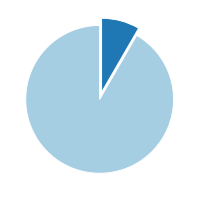

Proportion of cells selected by filter 1 for cell type 'PB' (out of all cells of this cell type)


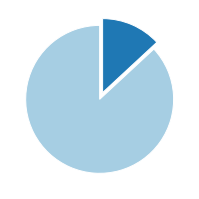

In [13]:
cell_types_by_filter = {0: ["Eos/Mast Prog", "CD16 mono"], 1: ["CD14 mono", "PB"]}

for f, cell_types in cell_types_by_filter.items():
    for ct in cell_types:
        print(f"Proportion of cells selected by filter {f} for cell type '{ct}' (out of all cells of this cell type)")
        ep.plot_selected_proportion(filter_response, "cell.type.coarse", ct, ratio_max_response=.3,
                                    filter_response_col=f"response_filter_{f}", palette="Paired",
                                    save=f"blish_status_selected_proportion_filter_{f}_"
                                    f"{ct.replace('/','_').replace(' ', '_')}",
                                    out_dir=plot_dir)

## Annotated UMAP

Here, we also recreate the annotated UMAP shown in the paper. We use the coarse cell types identified by the original authors ([Wilk et al. 2021](https://doi.org/10.1084/jem.20210582)).

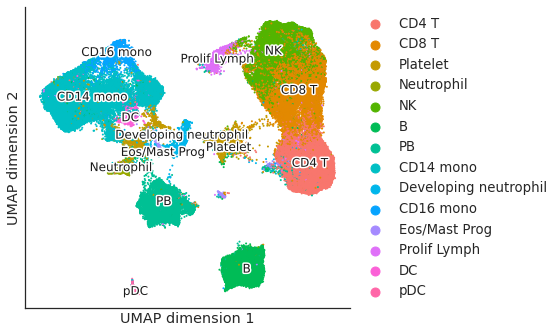

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

im = sns.scatterplot(x="UMAP_1", y="UMAP_2", hue="cell.type.coarse",
                     hue_order=list(cell_type_coarse_colors.keys()),
                     data=meta_data_umap, palette=cell_type_coarse_colors,
                     linewidth=0, s=4, rasterized=True)
for label in cell_type_coarse_colors.keys():
    x, y = meta_data_umap.loc[meta_data_umap["cell.type.coarse"] == label,["UMAP_1", "UMAP_2"]].median()
    if label == "Developing neutrophil":
        y += .5
    elif label == "Platelet":
        y -= .5
        x += .6
    ax.annotate(label, (x, y),
                horizontalalignment="center", verticalalignment="center", size=12, color="k",
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])
ax.set(xlabel="UMAP dimension 1", ylabel="UMAP dimension 2", xticks=[], yticks=[])
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False, markerscale=1.5)
sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, "blish_umap_coarse_cell_type.svg"), dpi=200)